<a href="https://colab.research.google.com/github/souptikmajumder/Credit_defaulters/blob/master/credit_card_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# from google.colab import files
# uploaded = files.upload()

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
link = 'https://drive.google.com/open?id=1Xiwu9ebWn3m34j_ERTIi_uipgOwlgPp2'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1Xiwu9ebWn3m34j_ERTIi_uipgOwlgPp2


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('creditcard.csv')  


In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import metrics
from sklearn import preprocessing

# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
df.shape

(284807, 31)

There are 284807 rows and 31 columns in the original dataframe.


In [8]:
#observe the different feature type present in the data
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


#### Class Representation

Let's Observe the distribution of classes for both fraudulent and non fraudulent cases

Class 0 represent non-fraudulent cases

Class 1 represent fraudulent cases

In [0]:
classes=df['Class'].value_counts()
normal_share=classes[0]/df['Class'].count()*100
fraud_share=classes[1]/df['Class'].count()*100

#### EDA on original dataset

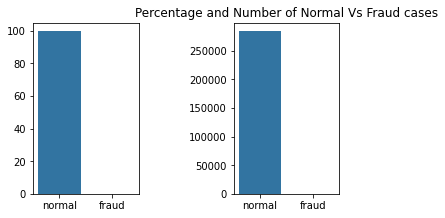

In [10]:
# Create a bar plot for the number and percentage of fraudulent vs non-fraudulent transcations
share_type=['normal','fraud']
share_per =[normal_share,fraud_share]
share_num =[classes[0],classes[1]]

fig, axs = plt.subplots(ncols=2)
sns.barplot(x=share_type,y=share_per,ax=axs[0])
sns.barplot(x=share_type,y=share_num,ax=axs[1])
fig.tight_layout(pad=5.0)
plt.title("Percentage and Number of Normal Vs Fraud cases")
plt.show()

(0.0, 25691.16)

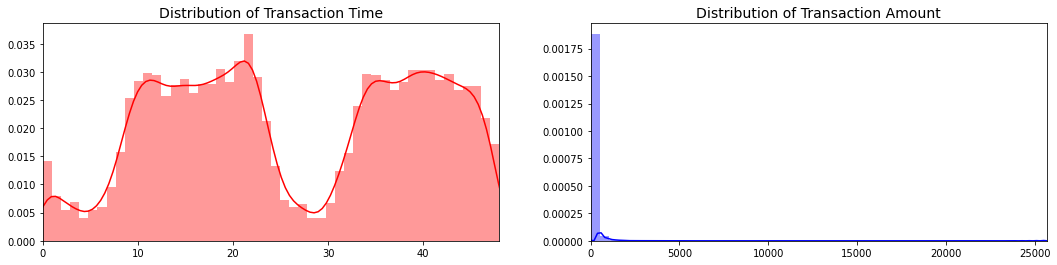

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

# Plot the distribution of 'Time' feature 
sns.distplot(df['Time'].values/(60*60), ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Time', fontsize=14)
ax[0].set_xlim([min(df['Time'].values/(60*60)), max(df['Time'].values/(60*60))])

# Plot the distribution of 'Amount' feature
sns.distplot(df['Amount'].values, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Amount', fontsize=14)
ax[1].set_xlim([min(df['Amount'].values), max(df['Amount'].values)])

In [0]:
# Seperate data as non-fraud and fraud cases
df_nonfraud = df[df.Class == 0] 
df_fraud    = df[df.Class == 1]

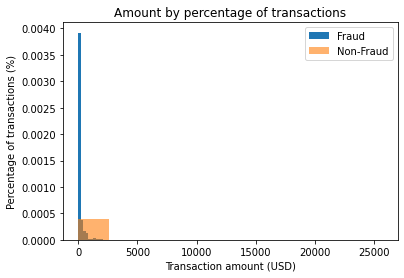

In [13]:
#plot histogram for amount for fraudulent and non-fraudulent cases
plt.hist(df_fraud.Amount, alpha=1,density= True, label='Fraud')
plt.hist(df_nonfraud.Amount, alpha=0.6,density = True, label='Non-Fraud')

plt.legend(loc='upper right')
plt.title("Amount by percentage of transactions")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions (%)")
plt.show()

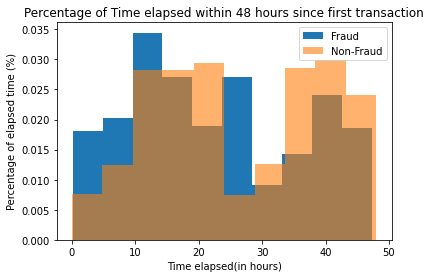

In [14]:
#plot histogram for time elapsed since the current and first transaction in hours for fraudulent and non-fraudulent cases

#fig, axs = plt.subplots(ncols=2)
plt.hist((df_fraud.Time/(60*60)), histtype='bar',density=True,alpha=1, label='Fraud')

plt.hist((df_nonfraud.Time/(60*60)), histtype='bar',density=True,alpha=0.6, label='Non-Fraud')

plt.legend(loc='upper right')
plt.title("Percentage of Time elapsed within 48 hours since first transaction")
plt.xlabel("Time elapsed(in hours)")
plt.ylabel("Percentage of elapsed time (%)")
plt.show()



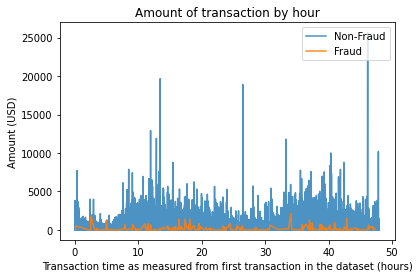

In [15]:
# Plot of transactions in 48 hours
plt.plot((df_nonfraud.Time/(60*60)), df_nonfraud.Amount, alpha=0.8, label='Non-Fraud')
plt.plot((df_fraud.Time/(60*60)), df_fraud.Amount, alpha=0.9, label='Fraud')
plt.title("Amount of transaction by hour")
plt.xlabel("Transaction time as measured from first transaction in the dataset (hours)")
plt.ylabel('Amount (USD)')
plt.legend(loc='upper right')
plt.show()

In [0]:
Original_Amount = df['Amount']
Original_time   = df['Time']

#saving values as amount and time has to be scaled since they are non PCA components


#### Feature correlation

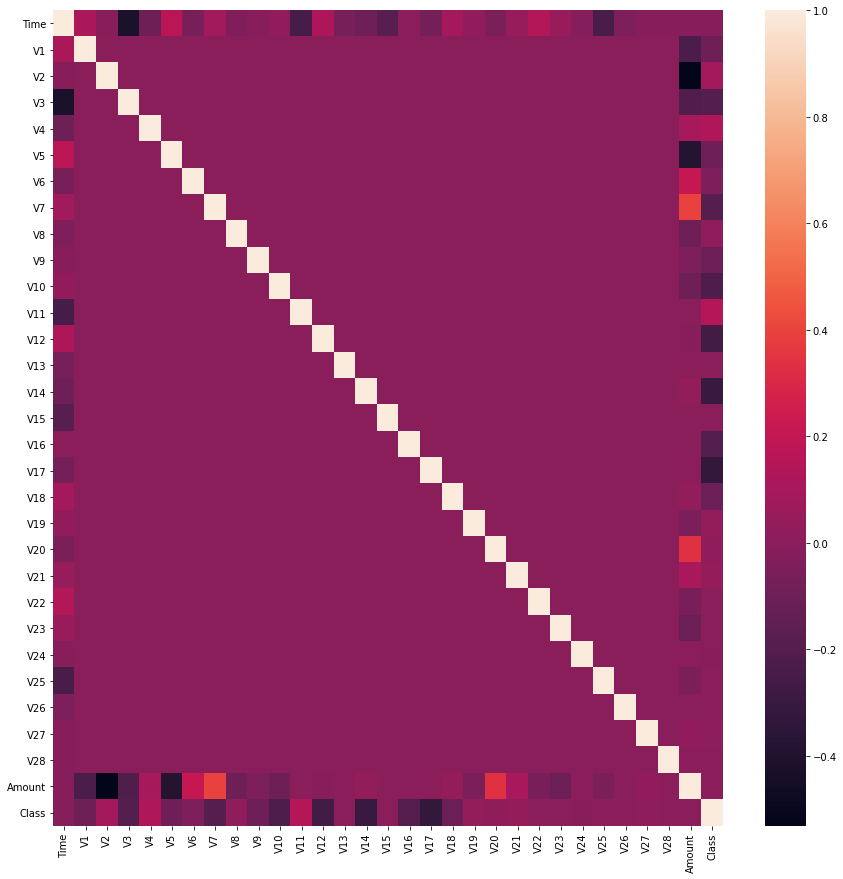

In [17]:
# Drop unnecessary columns
plt.figure(figsize=(15,15))
sns.heatmap(df.corr())

In [0]:
#Removing the columns with positive and negative correlation
#v2 is highly negatively correlated with amount
#v3 is highly negatively correlated with time
#v5 is highly negatively correlated with amount

#here, the threshold for correlation coefficient is kept at 0.5/-0.5

#hence dropping v2,v3,v5

df = df.drop(columns=['V2','V3','V5'])

 We have dropped columns V2, V3, V5 based on the high negative correlation from the existing dataframe.

### Splitting the dataset into train and test data


In [0]:
y = df['Class']
X=  df.drop(['Class'],axis=1)

In [20]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Class, dtype: int64

In [21]:
X.head()

,Time,V1,V4,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,1.378155,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.448154,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,0.379780,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1.0,-0.966272,-0.863291,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2.0,-1.158233,0.403034,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


In [22]:
#splitting data into train and test data
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,train_size=0.7,test_size=0.3,random_state=100)


print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(199364, 27)
(85443, 27)
(199364,)
(85443,)


#### Scaling features like Amount and Time as they were not one of the PCA Components

In [23]:
# Scale "Time" and "Amount"
from sklearn.preprocessing import StandardScaler, RobustScaler
rs = RobustScaler()
X_train['Amount'] = rs.fit_transform(X_train['Amount'].values.reshape(-1,1))
X_train['Time'] = rs.fit_transform(X_train['Time'].values.reshape(-1,1))

X_train.head()

,Time,V1,V4,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
7610,-0.871386,1.160485,-0.083757,0.309873,-0.503116,0.130077,1.279474,-0.528215,3.021936,-0.953080,2.523534,1.642896,0.223514,-0.059052,0.630296,-0.664479,-0.614659,-0.109200,-0.167768,-0.142183,0.148065,-0.261307,-0.052688,0.904879,-0.061990,-0.012372,-0.301442
190214,0.518571,2.054237,0.183785,-0.605905,0.102048,-0.183363,0.245017,0.229607,0.610062,1.214313,0.521753,0.351972,-0.676072,0.208449,-0.738125,-0.275378,0.612126,-0.169517,-0.263893,-0.636424,0.263862,-0.480128,-0.249245,0.206509,-0.072079,-0.074044,-0.287160
130590,-0.061742,1.434517,-2.432927,3.528638,-1.814737,0.859190,-1.680052,1.451927,-0.311041,-1.048697,0.620637,-0.406962,1.014342,0.189104,-0.129896,0.835635,-0.120798,-0.068984,-0.020924,0.089320,-0.120671,1.009913,0.510411,-0.038200,0.047306,0.031218,0.693150
247916,0.812454,-0.112311,-0.502613,-1.028247,0.964615,-0.112966,0.082123,-0.539202,-0.183169,0.161022,0.112076,-1.092514,-0.231143,0.111046,0.566802,-0.491726,-0.501441,0.135098,-0.334646,-0.734681,0.161824,0.984857,-0.439226,0.093359,0.332998,0.149541,-0.292707
55518,-0.442719,1.123477,0.533433,-0.068741,-0.575773,0.257399,0.235960,0.066642,1.635221,0.595421,-0.843761,0.467763,0.944421,0.460752,-0.391411,-0.042388,-0.463772,-0.170440,-0.003975,-0.052800,0.145628,0.219496,0.000863,0.215796,0.000743,0.013160,-0.221991


### Oversampling the train data

In [0]:
#Sampling training data based on oversampling techniques like random_oversampling,SMOTE,BorderLineSMOTE,ADASYN

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline # Inorder to avoid testing model on sampled data

# Create objects for oversampling methods

oversam = RandomOverSampler(random_state=0)
smote = SMOTE(kind='regular',random_state=0)
borderlinesmote = BorderlineSMOTE(kind='borderline-2',random_state=0)
adasyn = ADASYN()

X_oversam, y_oversam = oversam.fit_sample(X_train,y_train)
X_smote, y_smote = smote.fit_sample(X_train,y_train)
X_borderlinesmote, y_borderlinesmote = borderlinesmote.fit_sample(X_train,y_train)
X_adasyn,y_adasyn = adasyn.fit_sample(X_train,y_train)


In [25]:
X_oversam.shape #number of rows in random oversampled data

(398028, 27)

In [26]:
X_smote.shape #number of rows in oversampling done using SMOTE

(398028, 27)

In [27]:
X_borderlinesmote.shape #number of rows in oversampling done using borderline SMOTE

(398028, 27)

In [28]:
X_adasyn.shape ##number of rows in oversampling done using borderline SMOTE

(398029, 27)

# Model Building

Here, we use following models to evaluate our results:


1.   Logistic Regression
2.   Decision Tree Classifier
3.   Random Forest Classifier
4.   XGBoost 





#### Logistic Regression

In [0]:
X_test.head()

X_test['Amount'] = rs.transform(X_test['Amount'].values.reshape(-1,1))
X_test['Time'] = rs.transform(X_test['Time'].values.reshape(-1,1))


In [0]:
#running classification models on undersampled/original data
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#Training the model on Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)

#Obtain Logistic regression predictions

y_pred_logistic= log_reg.predict(X_test)


ROC AUC Score: 0.9685360259468913
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85301
           1       0.79      0.63      0.70       142

    accuracy                           1.00     85443
   macro avg       0.90      0.81      0.85     85443
weighted avg       1.00      1.00      1.00     85443

Confusion matrix:
 [[85278    23]
 [   53    89]]


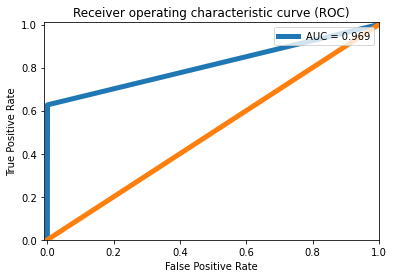

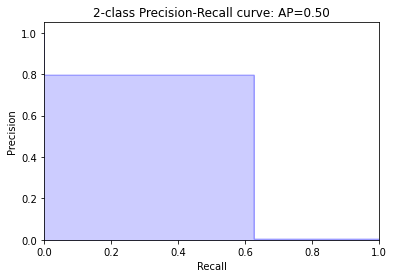

In [31]:
#Evaluating Model Performance
from sklearn.metrics import roc_curve,roc_auc_score, precision_recall_curve, average_precision_score,accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Create true and false positive rates
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred_logistic)

# Calculate Area Under the Receiver Operating Characteristic Curve 
probs_logistic = log_reg.predict_proba(X_test)
roc_auc_logistic = roc_auc_score(y_test, probs_logistic[:, 1])
print('ROC AUC Score:',roc_auc_logistic)

# Obtain precision and recall 
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_logistic)

# Calculate average precision 
average_precision_logistic = average_precision_score(y_test, y_pred_logistic)

# Define a roc_curve function
def plot_roc_curve(false_positive_rate,true_positive_rate,roc_auc):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
    plt.plot([0,1],[0,1], linewidth=5)
    plt.xlim([-0.01, 1])
    plt.ylim([0, 1.01])
    plt.legend(loc='upper right')
    plt.title('Receiver operating characteristic curve (ROC)')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Define a precision_recall_curve function
def plot_pr_curve(recall, precision, average_precision):
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

# Print the classifcation report and confusion matrix
print('Classification report:\n', classification_report(y_test, y_pred_logistic))
print('Confusion matrix:\n',confusion_matrix(y_true = y_test, y_pred = y_pred_logistic))

# Plot the roc curve 
plot_roc_curve(false_positive_rate,true_positive_rate,roc_auc_logistic)

# Plot recall precision curve
plot_pr_curve(recall, precision, average_precision_logistic)



We obtain an AUC-ROC score of 0.97 , with precision and recall of 0.90 and recall of 0.81 when trained with logistic regression on undersampled/original dataset.

In [32]:
#Training the model on Logistic Regression

rand_oversample_model_logistic = LogisticRegression().fit(X_oversam,y_oversam)
smote_model_logistic = LogisticRegression().fit(X_smote,y_smote)
smote_border_model_logistic = LogisticRegression().fit(X_borderlinesmote,y_borderlinesmote)
adasyn_model_logistic = LogisticRegression().fit(X_adasyn,y_adasyn)

#Obtain Logistic regression predictions
y_pred_lrand_oversample_logistic = rand_oversample_model_logistic.predict(X_test)
y_pred_smote_model_logistic = smote_model_logistic.predict(X_test)
y_pred_smote_border_model_logistic = smote_border_model_logistic.predict(X_test)
y_pred_adasyn_model_logistic = adasyn_model_logistic.predict(X_test)

#Model Evaluation 

#Random oversampling
print('Model Evaluation for Random Oversampling:\n')
print('Classifcation report:\n', classification_report(y_test, y_pred_lrand_oversample_logistic))
print('Confusion matrix:\n', confusion_matrix(y_true = y_test, y_pred = y_pred_lrand_oversample_logistic))
probs_logistic_rand_ovsmple = rand_oversample_model_logistic.predict_proba(X_test)
roc_auc_logistic_rand_ovsmple = roc_auc_score(y_test, probs_logistic_rand_ovsmple[:, 1])
print('ROC AUC Score:',roc_auc_logistic_rand_ovsmple)
print('*'*25)


#SMOTE oversampling
print('Model Evaluation for SMOTE Oversampling:\n')
print('Classifcation report:\n', classification_report(y_test, y_pred_smote_model_logistic))
print('Confusion matrix:\n', confusion_matrix(y_true = y_test, y_pred = y_pred_smote_model_logistic))
probs_logistic_SMTE = smote_model_logistic.predict_proba(X_test)
roc_auc_logistic_SMTE = roc_auc_score(y_test, probs_logistic_SMTE[:, 1])
print('ROC AUC Score:',roc_auc_logistic_SMTE)
print('*'*25)

#BorderSMOTE Oversampling
print('Model Evaluation for BorderLine SMOTE Oversampling:\n')
print('Classifcation report:\n', classification_report(y_test, y_pred_smote_border_model_logistic))
print('Confusion matrix:\n', confusion_matrix(y_true = y_test, y_pred = y_pred_smote_border_model_logistic))
probs_logistic_SMTE_border = smote_border_model_logistic.predict_proba(X_test)
roc_auc_logistic_SMTE_border = roc_auc_score(y_test, probs_logistic_SMTE_border[:, 1])
print('ROC AUC Score:',roc_auc_logistic_SMTE_border)
print('*'*25)


#ADASYN Oversampling
print('Model Evaluation for ADASYN Oversampling:\n')
print('Classifcation report:\n', classification_report(y_test, y_pred_adasyn_model_logistic))
print('Confusion matrix:\n', confusion_matrix(y_true = y_test, y_pred = y_pred_adasyn_model_logistic))
probs_logistic_adasyn = adasyn_model_logistic.predict_proba(X_test)
roc_auc_logistic_adasyn = roc_auc_score(y_test, probs_logistic_adasyn[:, 1])
print('ROC AUC Score:',roc_auc_logistic_adasyn)
print('*'*25)


Model Evaluation for Random Oversampling:

Classifcation report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     85301
           1       0.08      0.86      0.15       142

    accuracy                           0.98     85443
   macro avg       0.54      0.92      0.57     85443
weighted avg       1.00      0.98      0.99     85443

Confusion matrix:
 [[83921  1380]
 [   20   122]]
ROC AUC Score: 0.9659620422857187
*************************
Model Evaluation for SMOTE Oversampling:

Classifcation report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     85301
           1       0.07      0.87      0.13       142

    accuracy                           0.98     85443
   macro avg       0.54      0.93      0.56     85443
weighted avg       1.00      0.98      0.99     85443

Confusion matrix:
 [[83688  1613]
 [   18   124]]
ROC AUC Score: 0.9651339473754167
*********************

It is seen that with ADASYN OverSampling , we have the better model when model implemented is Logistic Regression.

In [33]:
##Logistic Regression with sampled Data using Pipeline
# Import the pipeline module we need for this from imblearn
from imblearn.pipeline import Pipeline 


# Define which resampling method and which ML model to use in the pipeline
model = LogisticRegression() 

# Define the pipeline, tell it to combine SMOTE with the Logistic Regression model
pipeline = Pipeline([('SMOTE', smote), ('Logistic Regression', model)])

# Fit your pipeline onto your training set and obtain predictions by fitting the model onto the test data 
pipeline.fit(X_train, y_train) 
y_predicted_logistic_final = pipeline.predict(X_test)

# Obtain the results from the classification report and confusion matrix 
print('Classifcation report:\n', classification_report(y_test, y_predicted_logistic_final))
print('Confusion matrix:\n', confusion_matrix(y_true = y_test, y_pred = y_predicted_logistic_final))

Classifcation report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     85301
           1       0.07      0.87      0.13       142

    accuracy                           0.98     85443
   macro avg       0.54      0.93      0.56     85443
weighted avg       1.00      0.98      0.99     85443

Confusion matrix:
 [[83688  1613]
 [   18   124]]


Since , ADASYN Oversampling has shown better results among other oversampling techniques, so for further models ADASYN Oversampling is only used

#### RandomForestClassifier

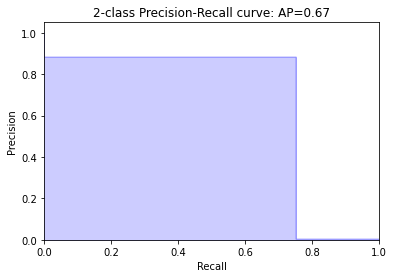

Accuracy Score:  0.9994265182636377
AUC ROC score:  0.9380957259718733
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85301
           1       0.88      0.75      0.81       142

    accuracy                           1.00     85443
   macro avg       0.94      0.88      0.91     85443
weighted avg       1.00      1.00      1.00     85443

Confusion matrix:
 [[85287    14]
 [   35   107]]


In [34]:
model_rndm_forest = RandomForestClassifier()
model_rndm_forest.fit(X_train, y_train)

# Obtain model predictions
y_predicted_rndm_frst = model_rndm_forest.predict(X_test)

# Predict probabilities
probs_rndm_frst = model_rndm_forest.predict_proba(X_test)

# Calculate average precision 
average_precision = average_precision_score(y_test, y_predicted_rndm_frst)

# Obtain precision and recall 
precision_rndm_frst, recall_rndm_frst, _ = precision_recall_curve(y_test, y_predicted_rndm_frst)

# Plot the recall precision tradeoff
plot_pr_curve(recall_rndm_frst, precision_rndm_frst, average_precision)

# Print the classifcation report and confusion matrix
print("Accuracy Score: ",accuracy_score(y_test, y_predicted_rndm_frst))
print("AUC ROC score: ", roc_auc_score(y_test, probs_rndm_frst[:,1]))

print('Classification report:\n', classification_report(y_test, y_predicted_rndm_frst))
print('Confusion matrix:\n',confusion_matrix(y_true = y_test, y_pred = y_predicted_rndm_frst))

In [35]:
##Random Forest Classifier with sampled Data using Pipeline
# Import the pipeline module we need for this from imblearn
from imblearn.pipeline import Pipeline 


# Define which resampling method and which ML model to use in the pipeline
model = RandomForestClassifier() 

# Define the pipeline, tell it to combine SMOTE with the Logistic Regression model
pipeline = Pipeline([('adasyn', adasyn), ('Random Forest Classifier', model)])

# Fit your pipeline onto your training set and obtain predictions by fitting the model onto the test data 
pipeline.fit(X_train, y_train) 
y_predicted_rdm_frst_final = pipeline.predict(X_test)

# Obtain the results from the classification report and confusion matrix 
print('Classifcation report:\n', classification_report(y_test, y_predicted_rdm_frst_final))
print('Confusion matrix:\n', confusion_matrix(y_true = y_test, y_pred = y_predicted_rdm_frst_final))

Classifcation report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85301
           1       0.89      0.77      0.82       142

    accuracy                           1.00     85443
   macro avg       0.94      0.88      0.91     85443
weighted avg       1.00      1.00      1.00     85443

Confusion matrix:
 [[85287    14]
 [   33   109]]


With Random Forest we have obtained the following accuracies:

  With OverSampling using adasyn:

1. precision of  **94** percent 
2. recall of **89** percent

Without Oversampling :

1. precision of **95** percent
2. recall of **88** percent  

#### XG Boost

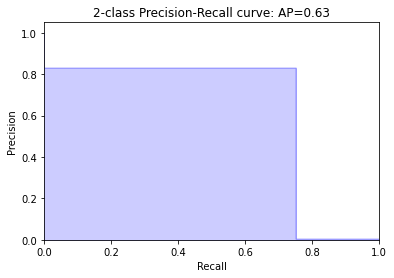

Accuracy Score:  0.9993328885923949
AUC ROC score:  0.974972223465174
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85301
           1       0.83      0.75      0.79       142

    accuracy                           1.00     85443
   macro avg       0.91      0.88      0.89     85443
weighted avg       1.00      1.00      1.00     85443

Confusion matrix:
 [[85279    22]
 [   35   107]]


In [36]:
## implementing xgboost algorithm
model_xgb_classifier = XGBClassifier(tree_method ='gpu_hist')
model_xgb_classifier.fit(X_train,y_train)

y_pred_xgb = model_xgb_classifier.predict(X_test)

# Predict probabilities
probs_xgb = model_xgb_classifier.predict_proba(X_test)

# Calculate average precision 
average_precision = average_precision_score(y_test, y_pred_xgb)

# Obtain precision and recall 
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_pred_xgb)

# Plot the recall precision tradeoff
plot_pr_curve(recall_xgb, precision_xgb, average_precision)


# Print the classifcation report and confusion matrix
print("Accuracy Score: ",accuracy_score(y_test, y_pred_xgb))
print("AUC ROC score: ", roc_auc_score(y_test, probs_xgb[:,1]))

print('Classification report:\n', classification_report(y_test, y_pred_xgb))
print('Confusion matrix:\n',confusion_matrix(y_true = y_test, y_pred = y_pred_xgb))


In [37]:
##XGB with sampled Data using Pipeline
# Import the pipeline module we need for this from imblearn

# Define which resampling method and which ML model to use in the pipeline
model = XGBClassifier(tree_method = 'gpu_hist') 

# Define the pipeline, tell it to combine SMOTE with the Logistic Regression model
#pipeline = Pipeline([('SMOTE', smote), ('XGB Classifier', model)])

adasyn = ADASYN(random_state=0)

X_adasyn_xgb, y_adasyn_xgb = adasyn.fit_sample(X_train,y_train)

x_train_adasyn_xgb = pd.DataFrame(X_adasyn_xgb) 

x_train_adasyn_xgb.columns = X_train.columns

y_train_adasyn_xgb = pd.Series(y_adasyn_xgb)
#print(X_smote_xgb)
# Fit your pipeline onto your training set and obtain predictions by fitting the model onto the test data 
#pipeline.fit(X_train, y_train)
model.fit(x_train_adasyn_xgb,y_train_adasyn_xgb) 
y_predicted_xgb_final = model.predict(X_test)
#model.predict(X_test)

# Obtain the results from the classification report and confusion matrix 
print('Classifcation report:\n', classification_report(y_test, y_predicted_xgb_final))
print('Confusion matrix:\n', confusion_matrix(y_true = y_test, y_pred = y_predicted_xgb_final))

Classifcation report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     85301
           1       0.05      0.88      0.10       142

    accuracy                           0.97     85443
   macro avg       0.53      0.93      0.54     85443
weighted avg       1.00      0.97      0.99     85443

Confusion matrix:
 [[83112  2189]
 [   17   125]]


With XGB Classfier following are the accuracy results:

1. Without Oversampling:

    Precision: 0.91

    Recall : 0.89

2. With Oversampling using ADASYN Oversampling:

    Precision : 0.53

    Recall    : 0.93    

# Result for best model performance

So ,out of all the tested models we see that, **random forest classifier** with **ADASYN oversampling** technique gives the best result.

**Precision : 0.90**

**Recall : 0.89**

# Hyperparameter  tuning for selected model

#### Grid Search for finding optimum parameter

In [38]:
##GridSearchCV to find optimal parameters for Random Forest Classifier 

from sklearn.model_selection import GridSearchCV

# Define the parameter sets to test
param_grid = {
    'n_estimators': [1, 30], 
    'max_features': ['auto', 'log2'],  
    'max_depth': [4, 8], 
    'criterion': ['gini', 'entropy']
}

# Define the model to use
model = RandomForestClassifier()

# Combine the parameter sets with the defined model
CV_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1)

# Fit the model to our training data and obtain best parameters
CV_model.fit(X_train, y_train)
CV_model.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 30}

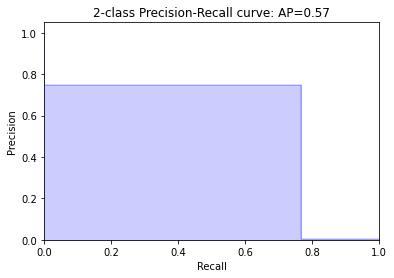

roc_auc_score: 0.9711323001843842
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85301
           1       0.75      0.77      0.76       142

    accuracy                           1.00     85443
   macro avg       0.87      0.88      0.88     85443
weighted avg       1.00      1.00      1.00     85443

Confusion_matrix:
 [[85264    37]
 [   33   109]]


In [39]:
##Model results using GridSearchCV


# Build a RandomForestClassifier using the GridSearchCV parameters
model_final = RandomForestClassifier(bootstrap=True,
                               class_weight = {0:1,1:12},
                               criterion = 'entropy',
                               n_estimators = 30,
                               max_features = 'log2',
                               min_samples_leaf = 10,
                               max_depth = 8,
                               n_jobs = -1,
                               random_state = 5)

# Fit the model to your training data and get the predicted results
model_final.fit(X_train,y_train)
y_predicted_final = model_final.predict(X_test)

# Calculate average precision 
average_precision = average_precision_score(y_test, y_predicted_final)

# Obtain precision and recall 
precision, recall, _ = precision_recall_curve(y_test, y_predicted_final)

# Plot the recall precision tradeoff
plot_pr_curve(recall, precision, average_precision)

# Print the roc_auc_score,Classifcation report and Confusin matrix
probs = model_final.predict_proba(X_test)
print('roc_auc_score:', roc_auc_score(y_test,probs[:,1]))
print('Classification report:\n',classification_report(y_test,y_predicted_final))
print('Confusion_matrix:\n',confusion_matrix(y_test,y_predicted_final))

In [40]:
#performing the hyperparameter tuning on oversampled data with randomforest classifier

# Define the model to use
model = RandomForestClassifier()

# Combine the parameter sets with the defined model
CV_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1)


pipeline = Pipeline([('ADASYN', adasyn), ('Cross Validation Model', CV_model)])

# Fit your pipeline onto your training set and obtain predictions by fitting the model onto the test data 
pipeline.fit(X_train, y_train) 
CV_model.best_params_


{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 30}

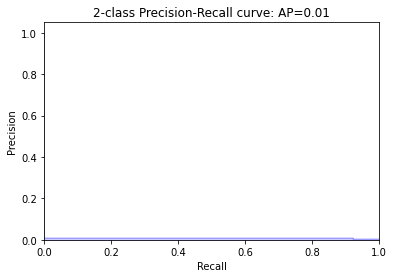

roc_auc_score: 0.9509435600956415
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.76      0.86     85301
           1       0.01      0.92      0.01       142

    accuracy                           0.76     85443
   macro avg       0.50      0.84      0.44     85443
weighted avg       1.00      0.76      0.86     85443

Confusion_matrix:
 [[64949 20352]
 [   11   131]]


In [41]:
##Model results using GridSearchCV with random forest using oversampling SMOTE


# Build a RandomForestClassifier using the GridSearchCV parameters
model = RandomForestClassifier(bootstrap=True,
                               class_weight = {0:1,1:12},
                               criterion = 'gini',
                               n_estimators = 30,
                               max_features = 'auto',
                               min_samples_leaf = 10,
                               max_depth = 8,
                               n_jobs = -1,
                               random_state = 5)


#model = RandomForestClassifier()

pipeline = Pipeline([('ADASYN', adasyn), ('Random Forest Classifier', model)])

# Fit the model to your training data and get the predicted results
pipeline.fit(X_train,y_train)
y_predicted = pipeline.predict(X_test)

# Calculate average precision 
average_precision = average_precision_score(y_test, y_predicted)

# Obtain precision and recall 
precision, recall, _ = precision_recall_curve(y_test, y_predicted)

# Plot the recall precision tradeoff
plot_pr_curve(recall, precision, average_precision)

# Print the roc_auc_score,Classifcation report and Confusin matrix
probs = model.predict_proba(X_test)
print('roc_auc_score:', roc_auc_score(y_test,probs[:,1]))
print('Classification report:\n',classification_report(y_test,y_predicted))

print('Confusion_matrix:\n',confusion_matrix(y_test,y_predicted))

Final confusion Matrix for random forest model:


In [42]:
print('Confusion_matrix:\n',confusion_matrix(y_test,y_predicted_final))

Confusion_matrix:
 [[85264    37]
 [   33   109]]


#### Voting Classifier 

A Voting Classifier is a machine learning model that trains on an ensemble of numerous models and predicts an output (class) based on their highest probability of chosen class as the output.

So, we are going to use the logistic regression model without oversampling, random classifier with oversampling and xgboost classifier without Oversampling to get an enesemble model, with accurate results

In [0]:
from sklearn.ensemble import VotingClassifier

#create a dictionary of our models
estimators = [('xgb', model_xgb_classifier), ('rf', model_final), ('log_reg', log_reg)]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='soft')

In [44]:
ensemble

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=3, min_child_weight=1,
                                            missing=None, n_estimators=100,
                                            n_jobs=1, nthread=None,
                                            objective='binary:logistic',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight...
                                                     random_state=5, verbose=0,
                                                     warm_start=False)),
    

In [0]:
ensemble.fit(X_train,y_train) # without oversampling data
ensemble_y_pred = ensemble.predict(X_test)

In [46]:
print('Confusion_matrix:\n',confusion_matrix(y_test,ensemble_y_pred))

Confusion_matrix:
 [[85274    27]
 [   38   104]]


In [0]:
model = ensemble 

smote = ADASYN(random_state=0)

X_adasyn, y_adasyn = adasyn.fit_sample(X_train,y_train)

X_train_ensemble_ovr = pd.DataFrame(X_adasyn) 

X_train_ensemble_ovr.columns = X_train.columns

y_train_ensemble_ovr = pd.Series(y_adasyn)

model.fit(X_train_ensemble_ovr,y_train_ensemble_ovr)
 
y_predicted_ensemble_ovr = model.predict(X_test)


In [48]:
print('Confusion_matrix:\n',confusion_matrix(y_test,y_predicted_ensemble_ovr))

Confusion_matrix:
 [[80923  4378]
 [   13   129]]


So, clearly we see that after using ensemble techniques based on Voting classifier , we have obtained better results without oversampling train data.

# Result

Below are the statistical results of the final model:

In [49]:
print('Confusion_matrix:\n',confusion_matrix(y_test,ensemble_y_pred))

Confusion_matrix:
 [[85274    27]
 [   38   104]]


Number of Transactions predicted to be non-fraudulent but are actually fraudulent : 27

Number of Transactions predicted to be fraudulent but are non fraudulent : 38

Number of correctly predicted non-fraudulent cases : 85274

Number of correctly predicted fraudulent cases : 104


ROC AUC Score: 0.9667863808211221
Average Precision Score: <function average_precision_score at 0x7fc758f1f488>


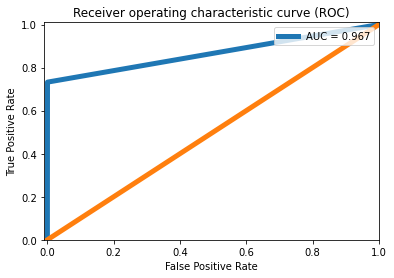

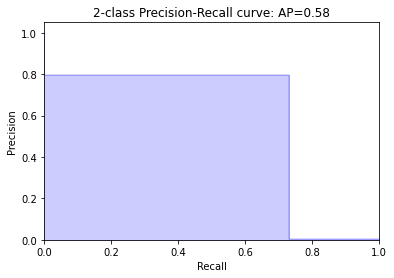

In [50]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, ensemble_y_pred)

# Calculate Area Under the Receiver Operating Characteristic Curve 
probs_ensemble = ensemble.predict_proba(X_test)
roc_auc_ensemble = roc_auc_score(y_test, probs_ensemble[:, 1])

print('ROC AUC Score:',roc_auc_ensemble)

# Obtain precision and recall 
precision_ensemble, recall_ensemble, thresholds_ensemble = precision_recall_curve(y_test, ensemble_y_pred)

# Calculate average precision 
average_precision_score_ensemble = average_precision_score(y_test, ensemble_y_pred)

print('Average Precision Score:',average_precision_score)

# Plot the roc curve 
plot_roc_curve(fpr,tpr,roc_auc_ensemble)

# Plot recall precision curve
plot_pr_curve(recall_ensemble, precision_ensemble, average_precision_score_ensemble)


In [51]:
print('Classifcation report:\n', classification_report(y_test, ensemble_y_pred))


Classifcation report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85301
           1       0.79      0.73      0.76       142

    accuracy                           1.00     85443
   macro avg       0.90      0.87      0.88     85443
weighted avg       1.00      1.00      1.00     85443

